In [ ]:
%pip install selenium
%pip install beautifulsoup4
%pip install plotly
%pip install seaborn
%pip install scipy
%pip install nbformat

In [71]:
%pip freeze | findstr nbformat


nbformat==5.10.4
Note: you may need to restart the kernel to use updated packages.


Etap 1: Zbieranie danych

In [1]:
from web_scraping import scrap_data

data = scrap_data()

The chromedriver version (131.0.6778.69) detected in PATH at I:\ChromeDriver\chromedriver.exe might not be compatible with the detected chrome version (132.0.6834.110); currently, chromedriver 132.0.6834.110 is recommended for chrome 132.*, so it is advised to delete the driver in PATH and retry


Etap 2: Czyszczenie danych

In [2]:
import pandas as pd
from cleaning import clean_data

# Dane wejściowe
df = pd.DataFrame(data)

# Przetwarzanie danych
df = clean_data(df)


In [4]:
df['Data wydania'] = pd.to_datetime(df['Data wydania'])

# Ekstrakcja roku z kolumny 'Data wydania' i zapisanie jako nowa kolumna 'Rok wydania'
df['Rok wydania'] = df['Data wydania'].dt.year

In [5]:
display(df)

,Tytuł,Tagi,Cena,Data wydania,Nacechowanie recenzji,Liczba recenzji,"Tag_2,5D",Tag_2D,Tag_3D,Tag_4X,...,Tag_Znaczące wybory,Tag_Zombie,Tag_Zręcznościowe,Tag_Łamigłówki,Tag_Łamigłówki platformowe,Tag_Łupy,Tag_Śledztwo,Tag_Świetna ścieżka dźwiękowa,Tag_Żeńska postać w roli głównej,Rok wydania
0,Cyberpunk 2077,"Cyberpunk, Otwarty świat, Nagość, RPG, Jednoos...",89.55,2020-12-10,Bardzo pozytywne,717578,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
1,Dying Light 2 Stay Human: Reloaded Edition,"Otwarty świat, Kooperacja, Zombie, Parkour, Wi...",65.99,2022-02-04,W większości pozytywne,137565,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2022
2,Marvel Rivals,"Free to Play, Wieloosobowe, Strzelanka z bohat...",0.00,2024-12-06,Bardzo pozytywne,183495,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024
3,Space Engineers 2,"Symulatory, Akcja, Strategiczne, Piaskownica, ...",138.99,2025-01-27,W większości pozytywne,638,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2025
4,Among Us,"Wieloosobowe, Sieciowa kooperacja, Dedukcyjne ...",10.79,2018-11-16,Bardzo pozytywne,612177,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,Space Prison,"Taktyczne turowe, Komiks, Strategiczne RPG, RP...",70.00,2024-07-18,Bardzo pozytywne,182,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024
488,Nuke Them All,"RTS, RTS akcji, Wojenne, Strategiczne, Taktyka...",91.99,2024-06-19,Bardzo pozytywne,86,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024
489,Aliens vs. Ghosts,"Akcja, Strzelanka, FPS, 3D, Perspektywa pierws...",34.68,2022-07-06,Bardzo pozytywne,379,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2022
490,Goodbye Deponia,"Przygodowe, Wskaż i kliknij, Komediowe, Jednoo...",9.19,2013-10-18,Bardzo pozytywne,1829,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2013


Etap 4: Analiza danych

Średnie kroczące szeregu czasowego

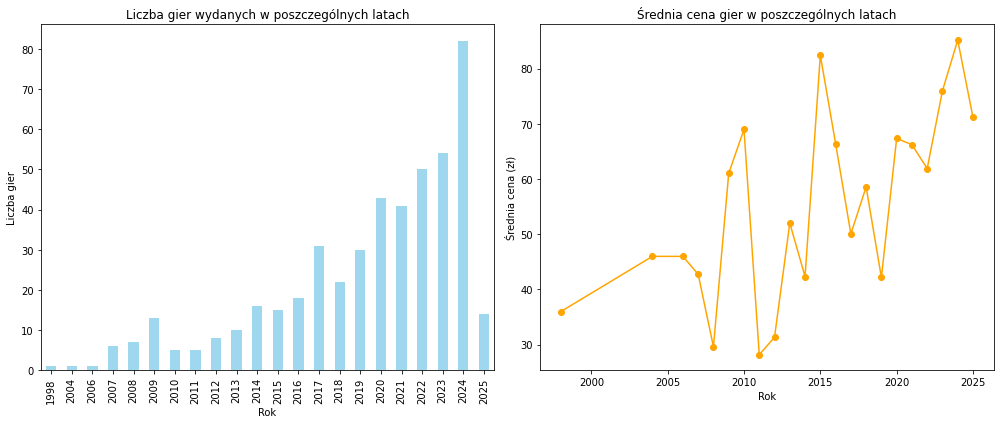

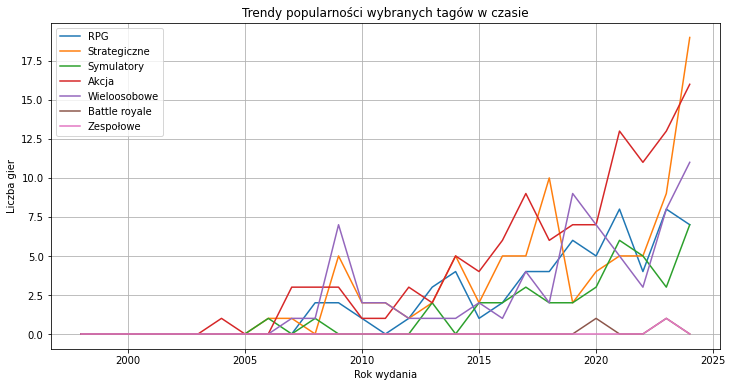

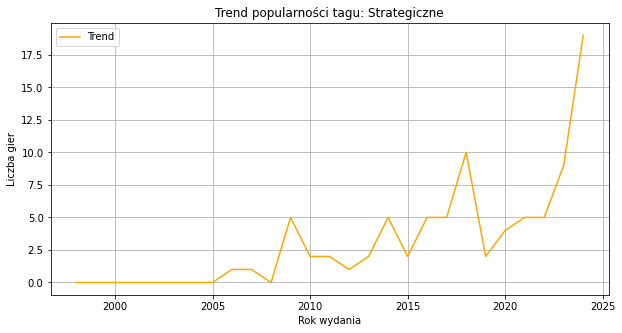

In [163]:
from analyzing import analyze_data

analyze_data(df)

Dekompozycja szeregu czasowego

Tagi - tabela korzyżowa

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Zliczanie liczby wystąpień każdego tagu
tag_counts = df['Tagi'].str.split(', ').explode().value_counts()

# Wybór najpopularniejszych tagów
top_tags = tag_counts.head(20).index

# Tworzenie macierzy współwystępowania tagów
tag_matrix = pd.DataFrame(0, index=top_tags, columns=top_tags)

for tags in df['Tagi'].dropna().str.split(', '):
    for tag1 in tags:
        for tag2 in tags:
            if tag1 in top_tags and tag2 in top_tags:
                tag_matrix.loc[tag1, tag2] += 1

# Obliczenie korelacji między tagami
tag_corr = tag_matrix.corr()


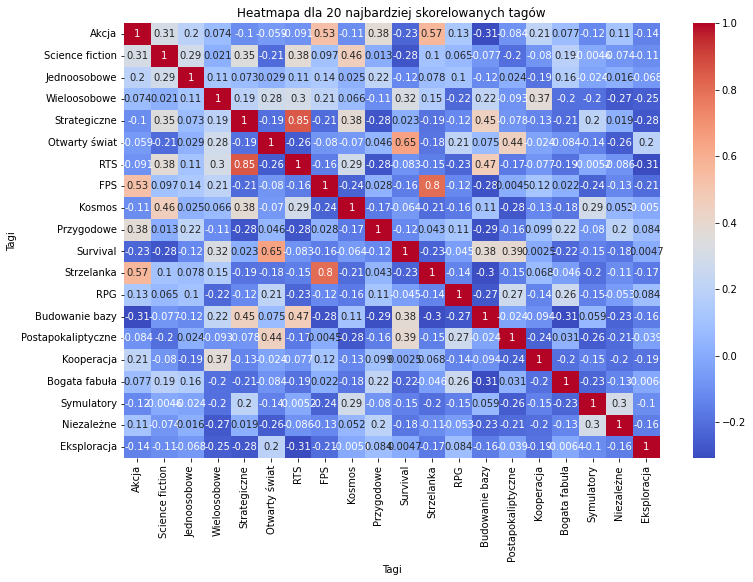

In [110]:
# Wybranie top 20 tagów z najwyższą sumaryczną korelacją
top_corr_tags = tag_corr.sum().sort_values(ascending=False).head(20).index
filtered_corr = tag_corr.loc[top_corr_tags, top_corr_tags]

# Heatmapa
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', xticklabels=top_corr_tags, yticklabels=top_corr_tags)
plt.title('Heatmapa dla 20 najbardziej skorelowanych tagów')
plt.show()


Etap 5: Dashboard

In [92]:
from collections import Counter
import pandas as pd
import plotly.express as px

def prepare_pie_chart_reviews(df, top_n=20):
    # Zliczanie liczby recenzji na tag
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_reviews = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            tag_reviews[tag] += df.iloc[idx]['Liczba recenzji']

    # Podział na najpopularniejsze tagi i kategorię "Other"
    top_tags = tag_reviews.most_common(top_n)
    other_count = sum(count for tag, count in tag_reviews.items() if tag not in dict(top_tags))
    
    # Przygotowanie danych do DataFrame
    pie_data = pd.DataFrame(top_tags, columns=['Tag', 'Review Count'])
    if other_count > 0:
        other_row = pd.DataFrame([{'Tag': 'Other', 'Review Count': other_count}])
        pie_data = pd.concat([pie_data, other_row], ignore_index=True)
    
    return pie_data

# Przygotowanie danych do wykresu
pie_chart_reviews_data = prepare_pie_chart_reviews(df)

# Wizualizacja
fig0 = px.pie(pie_chart_reviews_data, names='Tag', values='Review Count',
             title='Liczba opinii per tag (z kategorią "Other")',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig0.show()


In [93]:
import plotly.express as px

fig1 = px.histogram(df, x='Cena', nbins=20, title='Rozkład cen gier')
fig1.update_layout(xaxis_title='Cena', yaxis_title='Liczba gier')
fig1.show()


In [94]:
from collections import Counter

# Zliczanie wystąpień tagów
tag_counts = Counter()
for tags in df['Tagi']:
    # Przekształcenie stringa w listę tagów, zakładając, że są oddzielone przecinkami
    tag_list = tags.split(', ')
    tag_counts.update(tag_list)

# Przekształcenie wyników w DataFrame
tag_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)

# Wizualizacja
fig2 = px.bar(tag_df.head(20), x='Tag', y='Count', title='Najpopularniejsze tagi')
fig2.update_layout(yaxis_title='Liczba gier')
fig2.show()


In [95]:
# 1. Zależność między ceną a liczbą recenzji

import plotly.express as px

# Ustalamy kolejność nacechowania recenzji od najbardziej pozytywnych do najmniej pozytywnych
category_order = ['Przytłaczająco pozytywne', 'Bardzo pozytywne', 'W większości pozytywne', 'Pozytywne', 'Mieszane', 'W większości negatywne', 'Przytłaczająco negatywne']

# Tworzymy wykres
fig3 = px.scatter(df, x='Cena', y='Liczba recenzji', color='Nacechowanie recenzji',
                 title='Cena vs. liczba recenzji', labels={'Cena': 'Cena (zł)', 'Liczba recenzji': 'Liczba recenzji'},
                 hover_data=['Tytuł'],
                 category_orders={'Nacechowanie recenzji': category_order},
                 color_continuous_scale='RdYlGn',  # Ustawienie palety kolorów
                 color_discrete_map={'Przytłaczająco pozytywne': 'green', 'Bardzo pozytywne': 'lightgreen', 
                                     'W większości pozytywne': 'yellow', 'Pozytywne': 'yellow', 
                                     'Mieszane': 'orange', 'W większości negatywne': 'red', 'Przytłaczająco negatywne': 'darkred'})

# Wyświetlamy wykres
fig3.show()



In [96]:
# 2. Zależność między ceną a nacechowaniem recenzji

# Mapowanie nacechowania na wartości numeryczne
sentiment_map = {
    'Bardzo pozytywne': 3,
    'Pozytywne': 2,
    'Mieszane': 1,
    'Negatywne': 0
}
df['sentiment_score'] = df['Nacechowanie recenzji'].map(sentiment_map)

# Określenie kolejności dla 'Nacechowanie recenzji'
category_order = ['Przytłaczająco pozytywne', 'Bardzo pozytywne', 'W większości pozytywne', 'Pozytywne', 'Mieszane', 'W większości negatywne', 'Przytłaczająco negatywne']

# Scatter plot
fig4 = px.box(df, x='Nacechowanie recenzji', y='Cena', title='Cena w zależności od nacechowania recenzji',
             labels={'Cena': 'Cena (zł)', 'Nacechowanie recenzji': 'Nacechowanie recenzji'},
             category_orders={'Nacechowanie recenzji': category_order})  # Dodajemy sortowanie

fig4.show()



In [97]:
# Upewnij się, że Data wydania jest w formacie datetime
df['Data wydania'] = pd.to_datetime(df['Data wydania'], errors='coerce')

# Wyodrębnij rok i dodaj go do nowej kolumny
df['Rok wydania'] = df['Data wydania'].dt.year


In [103]:
# 3. Rozkład cen w zależności od daty wydania
import plotly.express as px
import pandas as pd

# Wykres liczby gier z podziałem na nacechowanie
# Grupowanie danych: liczba gier w zależności od nacechowania recenzji
count_data = df.groupby('Nacechowanie recenzji')['Tytuł'].count().reset_index()
count_data.rename(columns={'Tytuł': 'Liczba gier'}, inplace=True)

# Grupowanie danych: liczba gier w zależności od roku i nacechowania recenzji
grouped_data = df.groupby(['Rok wydania', 'Nacechowanie recenzji'])['Tytuł'].count().reset_index()
grouped_data.rename(columns={'Tytuł': 'Liczba gier'}, inplace=True)

# Wykres słupkowy z podziałem
fig5 = px.bar(grouped_data, x='Rok wydania', y='Liczba gier', color='Nacechowanie recenzji', barmode='stack',
             title='Liczba gier w zależności od roku wydania i nacechowania recenzji',
             labels={'Rok wydania': 'Rok wydania', 'Liczba gier': 'Liczba gier', 'Nacechowanie recenzji': 'Nacechowanie recenzji'},
             category_orders={'Nacechowanie recenzji': category_order})
fig5.show()

In [99]:
# Mapowanie tekstowego nacechowania recenzji na wartości numeryczne
sentiment_map = {
    'Przytłaczająco pozytywne': 4,
    'Bardzo pozytywne': 3,
    'W większości pozytywne': 2,
    'Mieszane': 1,
    'Negatywne': 0
}

df['sentiment_score'] = df['Nacechowanie recenzji'].map(sentiment_map).fillna(0)


In [100]:
# Obliczanie średnich ocen ważonych liczbą recenzji oraz średnich cen
def avg_sentiment_and_price_per_tag(df, top_n=20, min_games=3):
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_scores = Counter()
    tag_weights = Counter()
    tag_prices = Counter()
    tag_counts = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            sentiment_score = df.iloc[idx]['sentiment_score']
            review_count = df.iloc[idx]['Liczba recenzji']
            price = df.iloc[idx]['Cena']
            
            # Ważenie ocen liczbą recenzji
            tag_scores[tag] += sentiment_score * review_count
            tag_weights[tag] += review_count
            
            # Suma cen i liczba wystąpień
            tag_prices[tag] += price
            tag_counts[tag] += 1

    # Obliczanie średnich ocen i cen (filtr minimalnej liczby gier)
    avg_data = {
        tag: {
            'Average Sentiment': tag_scores[tag] / tag_weights[tag],
            'Average Price': tag_prices[tag] / tag_counts[tag],
            'Game Count': tag_counts[tag]
        }
        for tag in tag_scores if tag_counts[tag] >= min_games
    }
    avg_df = pd.DataFrame.from_dict(avg_data, orient='index').reset_index()
    avg_df.rename(columns={'index': 'Tag'}, inplace=True)
    return avg_df.sort_values('Average Sentiment', ascending=False).head(top_n), \
           avg_df.sort_values('Average Sentiment', ascending=True).head(top_n)


In [63]:
import plotly.graph_objects as go

# Obliczanie wyników
top_positive_tags, top_negative_tags = avg_sentiment_and_price_per_tag(df, top_n=20, min_games=3)

def create_dual_axis_chart(df, title):
    fig = go.Figure()

    # Słupki dla średniej oceny
    fig.add_trace(go.Bar(
        x=df['Tag'],
        y=df['Average Sentiment'],
        name='Średnia ocena',
        marker_color='#90CAF9',  # Łagodny pastelowy niebieski
        yaxis='y1'
    ))

    # Linie i punkty dla średniej ceny
    fig.add_trace(go.Scatter(
        x=df['Tag'],
        y=df['Average Price'],
        name='Średnia cena',
        mode='lines+markers',
        marker=dict(color='red', size=10),
        line=dict(width=2, dash='dot'),
        yaxis='y2'
    ))

    # Konfiguracja osi Y
    fig.update_layout(
        title=title,
        xaxis=dict(title='Tagi', tickangle=45),
        yaxis=dict(
            title='Średnia ocena',
            titlefont=dict(color='#90CAF9'),  # Dopasowany kolor tytułu osi
            tickfont=dict(color='#90CAF9'),
        ),
        yaxis2=dict(
            title='Średnia cena (zł)',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right'
        ),
        legend=dict(x=0.5, y=1.1, orientation='h')
    )

    return fig

# Przygotowanie wykresów dla najlepszych i najgorszych tagów
fig_positive = create_dual_axis_chart(top_positive_tags, 'Tagi z najlepszymi ocenami (ważone liczbą recenzji)')
fig_negative = create_dual_axis_chart(top_negative_tags, 'Tagi z najgorszymi ocenami (ważone liczbą recenzji)')

# Wyświetlenie wykresów
fig_positive.show()
fig_negative.show()


In [121]:
# Dodanie fig6 do dashboardu
for trace in fig6.data:  # Iteracja po wszystkich śladach fig6
    dashboard.add_trace(trace, row=3, col=1)



In [123]:
from plotly.subplots import make_subplots

# Tworzenie dashboardu z dynamicznym układem
dashboard = make_subplots(
    rows=3, cols=1,  # Każdy wykres w swoim rzędzie
    specs=[
        [{"type": "xy"}],  # Rząd 1: Fig1 zajmuje całą szerokość
        [{"type": "xy"}],  # Rząd 2: Fig4 zajmuje całą szerokość
        [{"type": "xy"}]   # Rząd 3: Fig6 z dwiema osiami y
    ],
    subplot_titles=[
        "Liczba gier i recenzji (Fig1)",
        "Popularność tagów w czasie (Fig4)",
        "Tagi z najlepszymi ocenami (Fig6)"
    ]
)

# Dodanie fig1 do pierwszego wiersza
dashboard.add_traces(fig1.data, rows=1, cols=1)

# Dodanie fig4 do drugiego wiersza
dashboard.add_traces(fig4.data, rows=2, cols=1)

# Dodanie fig6 do trzeciego wiersza (z dwiema osiami Y)
for trace in fig6.data:
    dashboard.add_trace(trace, row=3, col=1)

# Ustawienia układu
dashboard.update_layout(
    height=1200,  # Większa wysokość dashboardu dla lepszej czytelności
    width=1200,
    title_text="Dashboard analizy gier",
    showlegend=True
)

# Wyświetlenie dashboardu
dashboard.show()


In [122]:
dashboard.show()

In [112]:
from plotly.subplots import make_subplots

# Tworzenie układu z różnymi typami wykresów
dashboard = make_subplots(
    rows=2, cols=1, 
    specs=[[{"type": "pie"}], [{"type": "xy"}]],  # Pierwszy wiersz: pie, Drugi wiersz: xy
    subplot_titles=["Liczba opinii per tag", "Top tagi z najlepszymi ocenami"]
)

# Dodanie wykresu kołowego (fig0) do pierwszego wiersza
dashboard.add_traces(fig0.data, rows=1, cols=1)

# Dodanie wykresu słupkowego (fig6 = fig_positive) do drugiego wiersza
dashboard.add_traces(fig_positive.data, rows=2, cols=1)

# Ustawienia układu
dashboard.update_layout(height=800, width=1200, title_text="Dashboard analizy gier")
dashboard.show()


In [88]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(cross_table):
    chi2, _, _, _ = chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi2 = chi2 / n
    r, k = cross_table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Eksplodowanie tagów z resetowaniem indeksu
exploded_tags = df[['Nacechowanie recenzji', 'Tagi']].copy()
exploded_tags = exploded_tags.assign(Tag=exploded_tags['Tagi'].str.split(', ')).explode('Tag').reset_index(drop=True)

# Tabela krzyżowa: Nacechowanie recenzji a tagi
cross_table = pd.crosstab(exploded_tags['Nacechowanie recenzji'], exploded_tags['Tag'])

# Obliczenie Cramer's V
cramers_v_value = cramers_v(cross_table)
print(f"Cramer's V: {cramers_v_value:.2f}")

Cramer's V: 0.37


Etap 6: Modelowanie

In [ ]:
# Modelowanie: Zdecyduj, czy problem to klasyfikacja, czy regresja. Wykorzystaj odpowiednie modele uczenia maszynowego (np. drzewa decyzyjne, regresję logistyczną dla klasyfikacji; regresję liniową, lasy losowe dla regresji) z biblioteki `scikit-learn` i oceń ich wyniki przy użyciu takich miar jak dokładność (accuracy), F1 score lub R-kwadrat (R²), w zależności od typu danych i analizy.

# 1. na podstawie tagów, ceny i roku wydania oceń, jakie opinie ma gra - klasyfikacja
# 2. na podstawie tagów, opinii, liczby opinii, roku wydania zgadnij, jaką cenę ma gra - regresja

In [125]:
print("Unikalne klasy w danych:", y.unique())
print("Liczba klas w danych:", len(y.unique()))


Unikalne klasy w danych: [0 7 5 2 1 6 4 3]
Liczba klas w danych: 8


In [126]:
# Dopasowanie nazw klas do danych
actual_classes = sorted(y.unique())  # Faktyczne klasy w danych
actual_class_names = [label_encoder.inverse_transform([cls])[0] for cls in actual_classes]  # Odpowiednie nazwy klas

# Aktualizacja raportu klasyfikacji
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred, target_names=actual_class_names))


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

In [133]:
# Przykład przekształcenia daty na cechy numeryczne
df['Year'] = df['Data wydania'].dt.year  # rok
df['Month'] = df['Data wydania'].dt.month  # miesiąc
df['Day'] = df['Data wydania'].dt.day  # dzień

# Usunięcie oryginalnej kolumny z datą, jeśli jest już niepotrzebna
df.drop(['Data wydania'], axis=1, inplace=True)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Zakładając, że 'Nazwa_gry' to kolumna tekstowa
if 'Nazwa_gry' in df.columns:
    encoder = LabelEncoder()
    df['Nazwa_gry'] = encoder.fit_transform(df['Nazwa_gry'])

# Zakładając, że inne kolumny mogą też być kategorialne
df = pd.get_dummies(df)

# Przygotowanie danych
X = df.drop(['Tag_Akcja'], axis=1)  # Usuwamy kolumnę Tag_Akcja z cech
y = df['Tag_Akcja']  # Nasza cecha docelowa

# Zakładając, że wszystkie cechy do skalowania są już numeryczne
scaler = StandardScaler()

# Wybieranie tylko kolumn numerycznych do skalowania
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Budowanie modelu
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność:", accuracy)
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))


Dokładność: 0.6145833333333334
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.67      0.85      0.75        66
           1       0.23      0.10      0.14        30

    accuracy                           0.61        96
   macro avg       0.45      0.47      0.45        96
weighted avg       0.54      0.61      0.56        96



In [137]:
from sklearn.metrics import roc_curve

# Obliczenie prawdopodobieństw
probabilities = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Można zobaczyć różne progi i wybrać ten, który daje najlepszy kompromis między FPR a TPR


In [138]:
y_pred = clf.predict(X_test)

In [136]:
from sklearn.linear_model import LogisticRegression

# Ustawienie "balanced" automatycznie dostosowuje wagi odwrotnie proporcjonalnie do częstości klas
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Dokładność:", accuracy_score(y_test, y_pred))
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred))


Dokładność: 0.46875

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.71      0.38      0.50        66
           1       0.33      0.67      0.44        30

    accuracy                           0.47        96
   macro avg       0.52      0.52      0.47        96
weighted avg       0.59      0.47      0.48        96



In [155]:
from modeling import predict_tag

# Przykładowe użycie funkcji
target_tag = 'Tag_Strategiczne'  # Przykładowy tag do przewidzenia
accuracy, report = predict_tag(df, target_tag)

print("Dokładność:", accuracy)
print("\nRaport klasyfikacji:\n", report)


Dokładność: 0.8526315789473684

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91        81
           1       0.50      0.86      0.63        14

    accuracy                           0.85        95
   macro avg       0.74      0.85      0.77        95
weighted avg       0.90      0.85      0.87        95



In [152]:
df

,Tytuł,Tagi,Cena,Data wydania,Nacechowanie recenzji,Liczba recenzji,"Tag_2,5D",Tag_2D,Tag_3D,Tag_4X,...,Tag_Zespołowe,Tag_Znaczące wybory,Tag_Zombie,Tag_Zręcznościowe,Tag_Łamigłówki,Tag_Łamigłówki platformowe,Tag_Łupy,Tag_Śledztwo,Tag_Świetna ścieżka dźwiękowa,Tag_Żeńska postać w roli głównej
0,Cyberpunk 2077,"Cyberpunk, Otwarty świat, Nagość, RPG, Jednoos...",89.55,2020-12-10,Bardzo pozytywne,717578,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dying Light 2 Stay Human: Reloaded Edition,"Otwarty świat, Kooperacja, Zombie, Parkour, Wi...",65.99,2022-02-04,W większości pozytywne,137565,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Marvel Rivals,"Free to Play, Wieloosobowe, Strzelanka z bohat...",0.00,2024-12-06,Bardzo pozytywne,183495,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Space Engineers 2,"Symulatory, Akcja, Strategiczne, Piaskownica, ...",138.99,2025-01-27,W większości pozytywne,597,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Among Us,"Wieloosobowe, Sieciowa kooperacja, Dedukcyjne ...",10.79,2018-11-16,Bardzo pozytywne,612177,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,MDK 2,"Strzelanka z perspektywą trzeciej osoby, Strze...",35.99,2009-09-17,Bardzo pozytywne,190,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
481,Starcom: Nexus,"Kosmos, Science fiction, RPG, Akcja, Eksploracja",35.99,2019-12-12,Bardzo pozytywne,1864,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
482,Starsand,"Survivalowe w otwartym świecie, Survival, Otwa...",35.99,2022-11-17,W większości pozytywne,745,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
483,Odysseus Kosmos and his Robot Quest (Complete ...,"Wskaż i kliknij, Klimatyczne, Pikselowa grafik...",67.99,2017-12-01,Bardzo pozytywne,114,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
